# Second Lab Session: Solving the 1D bi-Harmonic Equation 

Solves the one-dimensional bi-harmonic equation. 

## Import Packages  

In [2]:
using LinearAlgebra 
using SparseArrays 

using BenchmarkTools
using Profile

using Plots 

## Section 1: Code for 1D-Poisson Matrix 

In [3]:
function buildMat1D(N)
  Nm1 = N-1; Np1 = N+1 
  h = 1/N; h2 = h*h; h=1
  stencil = [-1/h2, 2/h2, -1/h2]; 
  #..Allocate row, column and value vector 
  I = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  J = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  vals = zeros(Float64,3*Nm1)
  #..Construct row, column and value vector 
  for i in 2:N
    offset = 3*(i-2)
    I[[offset+1, offset+2, offset+3]] = [i,i,i]
    J[[offset+1, offset+2, offset+3]] = [i-1,i,i+1]
    vals[[offset+1, offset+2, offset+3]] = stencil
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
    A[1,1] = 1; A[end,end]=1; A[1,2] =0; A[end,end-1]=0; 
  return A 
end 

buildMat1D (generic function with 1 method)

## Section 2: 1D-Poisson with Point-Source as Source Function
The amplitude of the point source is set to obtain a maximal deflection equal one, independently of the mesh size. The computed solution corresponds to the bending moment of a beam, clamped at both points, subject to a load. 

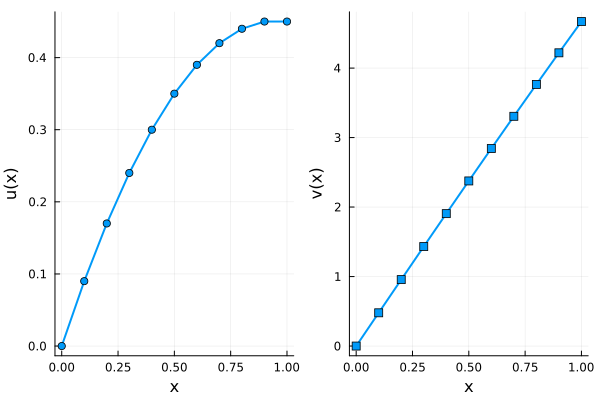

In [4]:
#..construct the 1D mesh. Choose N to be even such that the node N/2 lies in the middle 
#..of the interval  
N = 10; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..construct the source function 
f = ones(size(x)); 
#f[div(N,2)+1] = 4/h;
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with Dirichlet the boundary conditions
A = buildMat1D(N);
f[1]=0;
A[end,end] = 1; A[end,end-1] = -1; f[end]=0; 

#..solve the linear system
u = A \ f; 

#..solve the linear system with squared operator 
#..need to modify row of B to get boundary conditions correctly implemented 
#..see e.g. https://people.sc.fsu.edu/~jburkardt/m_src/fem1d/fem1d.html 
B = A*A; 
v = B \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
p2=plot(x,v,shape=:square,lw=2,legend=false)
xlabel!("x") 
ylabel!("v(x)")
plot(p1,p2)

## Section 3: 1D-Poisson with Dirichlet and Neumann in left-end point
We employ the first and last row of the matrix and the rhs-vector to enforce the Dirichlet and Neumann boundary condition in the left-most boundary node. Does this work? Should you have a fourth order equation instead?  

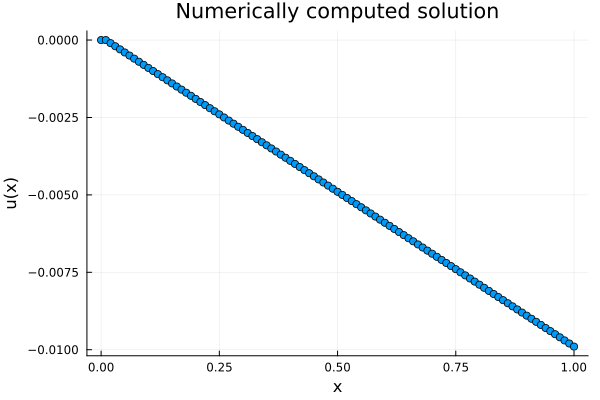

In [5]:
#..construct the 1D mesh. Choose N to be even such that the node N/2 lies in the middle 
#..of the interval  
N = 100; Np1 = N+1; h=1/N; h2=h*h; 
x = Vector(0:h:1); 

#..construct the source function 
f = zeros(size(x));
f[end] = 1
#f[div(N,2)+1] = 4/h;
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with Dirichlet the boundary conditions
A = buildMat1D(N);

# adapt to desired boundary conditions 
A[2,1] = -1; A[2,2]=1; A[2,3]=0;
A[end,end] = -1/h2; A[end,end-1] = 1/h2; 

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## Section 4: 1D-bi-Harmonic Equation as Source Function

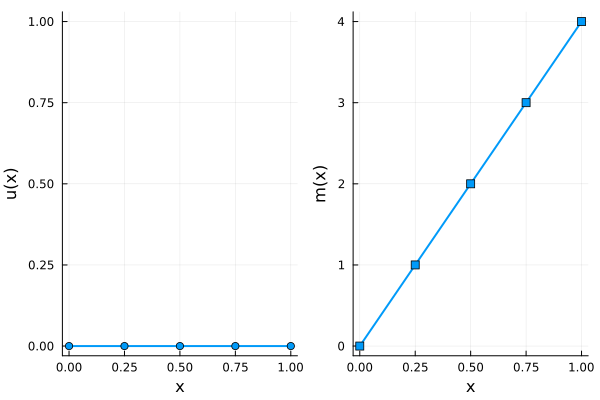

In [7]:
#..construct the 1D mesh. Choose N to be even such that the node N/2 lies in the middle 
#..of the interval  
N = 4; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..construct the source function 
f = zeros(size(x)); 
f[div(N,2)+1] = 0*4/h;
if false 
  plot(x,f)
end 

#..construct the coefficient matrix without the boundary conditions 
Au = buildMat1D(N); Am = Au;

#..handle the boundary conditions in the matrix and right-hand side vector 
#Au[1,1]   = 1;          Au[1,2]   = 0;          
#Au[end,1] = 1;          Au[end,2] = -1;     
 
#Am[1,end] = 1;          Am[1,1]   = 0;   Am[1,2]   = 0;          
Am[end,end] = 1;        Am[end,end-1] = -1;     

e  = zeros(size(x));
I  = Diagonal(e);
O  = zeros(Np1,Np1); 
AA = [Au -I; O Am];
o  = zeros(Np1); 
f[end] = 1; 
ff = [o;f]; 

#..solve the linear system
uu = AA \ ff;
u = uu[1:div(end,2)]
m = uu[div(end,2)+1:end]

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
p2=plot(x,m,shape=:square,lw=2,legend=false)
xlabel!("x") 
ylabel!("m(x)")
plot(p1,p2)

In [41]:
Au

101×101 Tridiagonal{Float64, Vector{Float64}}:
      1.0       0.0        ⋅         ⋅   …        ⋅         ⋅         ⋅ 
 -10000.0   20000.0  -10000.0        ⋅            ⋅         ⋅         ⋅ 
       ⋅   -10000.0   20000.0  -10000.0           ⋅         ⋅         ⋅ 
       ⋅         ⋅   -10000.0   20000.0           ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅   -10000.0           ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅   …        ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅   …        ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    

## Section 5: Sandbox 

## References 